# Общая информация:

-Отсутствуют дубликаты

-Отсутствуют пропуски

Задачи:

- Применить масштабирование для данных (done)

- Добавить ещё больше фичей. Возможно сделать PCA чтобы создать дополнительных признака

- Попробовать разные модели МО

- Поиграться с найтройками модели



In [7]:
# базовые библиотека
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from datetime import datetime
from collinearity import SelectNonCollinear

# кодирование и масштабирование
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import optuna

# цвет текста
from IPython.core.display import display, HTML

#Модели обучения
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# метрики
from sklearn.metrics import r2_score, recall_score

from sklearn.utils import shuffle
import math

SEED = 0

In [8]:
subway = pd.read_csv('subway.csv')

In [9]:
train = pd.read_csv('train_dataset_train.csv', index_col='id', parse_dates=['pass_dttm'])

In [10]:
def data_info(df):
    """Функция первичного знакомства с данными"""
    display(df.head(10))
    print('Общая информация:')
    display(df.info())
    print('Общая статистика:')
    display(df.describe())
    print('Дубликаты:')
    display(df.duplicated().sum())
    print('Пропуски:')
    for col in df.columns:
        pct_missing = np.mean(df[col].isna())
        print('{} - {}%'.format(col, round(pct_missing*100,2)))
    print('Матрица диаграмм:')
    pd.plotting.scatter_matrix(df,figsize=(10,10))
    plt.suptitle("Матрица диаграмм зависимостей", size=20)
    plt.show()
    print('Heatmap корреляций:')
    plt.figure(figsize=(10, 10))
    heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG') 
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);
    plt.show()
    print('Boxblot для оценки выбросов:')
    df.drop(columns='id').plot(kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(15, 10)
    )

    # increase spacing between subplots
    plt.subplots_adjust(wspace=0.8) 
    plt.show()

In [11]:
def up_sampling(df, size_values: int):
    """
    Функция увеличивает количество объектов чей таргет представлени < size_values
    
    Вызывается рекурсивно в случае если обработаны не все метки
    Базовый случай замешивает все добавленные записи и сбрасывает индекс
    """
    
    count_label_sort = df.groupby('label').size().to_frame('label_size').query("label_size < @size_values").sort_values(by='label_size', ascending=False)
    
    if len(count_label_sort) == 0: # базовый случай
        new_df = shuffle(df, random_state=SEED).reset_index(drop=True)
        return  new_df 
    
    else:
        
        index_0 = count_label_sort.index[0] # первый индекс сортированных значений
        
        label_size = count_label_sort.iloc[0,0] # количество значений метки в датасете
        
        repeat = (size_values // label_size) +1

        upsampled_part = pd.concat(
                                    [df[df['label'] != index_0]] + 
                                    [df[df['label'] == index_0]] * repeat)
        return up_sampling(upsampled_part, size_values)
    
def down_sampling(df, size_values: int):
    """
    Функция уменьшает количество объектов чей таргет представлен > size_values
    
    Вызывается рекурсивно в случае если обработаны не все метки
    Базовый случай замешивает все добавленные записи и сбрасывает индекс
    """
    
    count_label_sort = df.groupby('label').size().to_frame('label_size').query("label_size > @size_values").sort_values(by='label_size', ascending=False)
    
    if len(count_label_sort) == 0: # базовый случай
        new_df = shuffle(df, random_state=SEED).reset_index(drop=True)
        return  new_df 
    
    else:
        
        index_0 = count_label_sort.index[0] # первый индекс сортированных значений
        label_size = count_label_sort.iloc[0,0] # количество значений метки в датасете
        
        fract = (size_values * 100 /  label_size) / 100

        downsampled_part = pd.concat(
                                    [df[df['label'] != index_0]] + 
                                    [df[df['label'] == index_0].sample(frac=fract, random_state=SEED)])
        
        return down_sampling(downsampled_part, size_values)

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
id,,,,,,,,,,,
1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017
6,A18692B5936C0B1689B8B3D904959534,СК студента 30 дней,103,Аэропорт ( Северный ),2003,Аэропорт,2,Замоскворецкая,2022-09-12 05:02:56,148.683333,11012
7,31CEE36AE183CF0EF7E4687993E8CC0E,Пропуск FacePay,2258,Косино (Первый),15001,Косино,15,Некрасовская,2022-09-12 05:02:59,192.150000,15001
8,EDFA01D6A6157E0716138DAA074ED974,Пропуск FacePay,2117,Котельники(Первый),7007,Котельники,7,Таганско-Краснопресненская,2022-09-12 05:03:00,229.400000,7014
9,532322AC5CDB5C0FE8C1F6308F9C2B7F,90 дней,103,Аэропорт ( Северный ),2003,Аэропорт,2,Замоскворецкая,2022-09-12 05:03:03,720.616667,5007


Общая информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1091021 entries, 1 to 1091021
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   ticket_id       1091021 non-null  object        
 1   ticket_type_nm  1091021 non-null  object        
 2   entrance_id     1091021 non-null  int64         
 3   entrance_nm     1091021 non-null  object        
 4   station_id      1091021 non-null  int64         
 5   station_nm      1091021 non-null  object        
 6   line_id         1091021 non-null  int64         
 7   line_nm         1091021 non-null  object        
 8   pass_dttm       1091021 non-null  datetime64[ns]
 9   time_to_under   1091021 non-null  float64       
 10  label           1091021 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 99.9+ MB


None

Общая статистика:


,entrance_id,station_id,line_id,time_to_under,label
count,1.091021e+06,1.091021e+06,1.091021e+06,1.091021e+06,1.091021e+06
mean,8.581884e+02,8.601452e+03,8.590013e+00,5.104668e+02,7.723527e+03
std,9.003577e+02,1.247133e+04,1.247157e+01,2.328452e+02,1.167015e+04
min,2.000000e+01,1.002000e+03,1.000000e+00,3.001667e+01,1.002000e+03
25%,2.150000e+02,3.018000e+03,3.000000e+00,3.229500e+02,3.006000e+03
50%,3.370000e+02,7.009000e+03,7.000000e+00,5.686833e+02,6.013000e+03
75%,2.087000e+03,9.022000e+03,9.000000e+00,6.838833e+02,9.012000e+03
max,2.466000e+03,8.101600e+04,8.100000e+01,1.437417e+03,8.101600e+04


Дубликаты:


0

Пропуски:
ticket_id - 0.0%
ticket_type_nm - 0.0%
entrance_id - 0.0%
entrance_nm - 0.0%
station_id - 0.0%
station_nm - 0.0%
line_id - 0.0%
line_nm - 0.0%
pass_dttm - 0.0%
time_to_under - 0.0%
label - 0.0%
Матрица диаграмм:


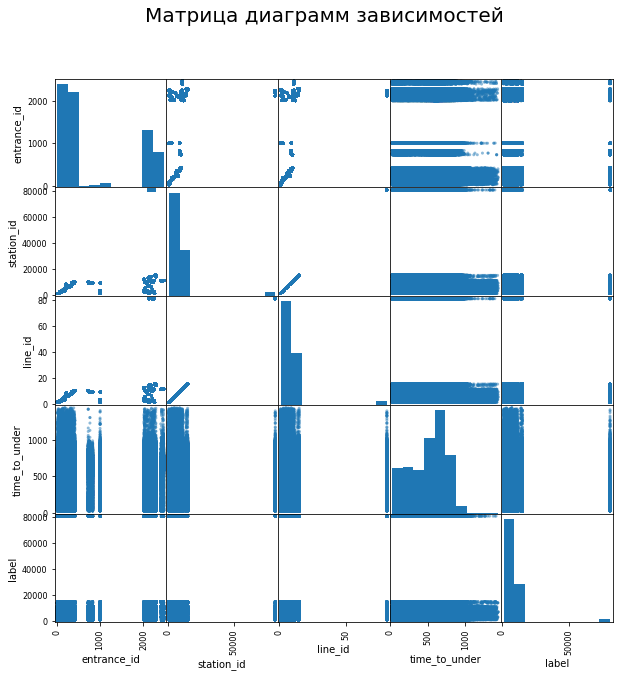

Heatmap корреляций:


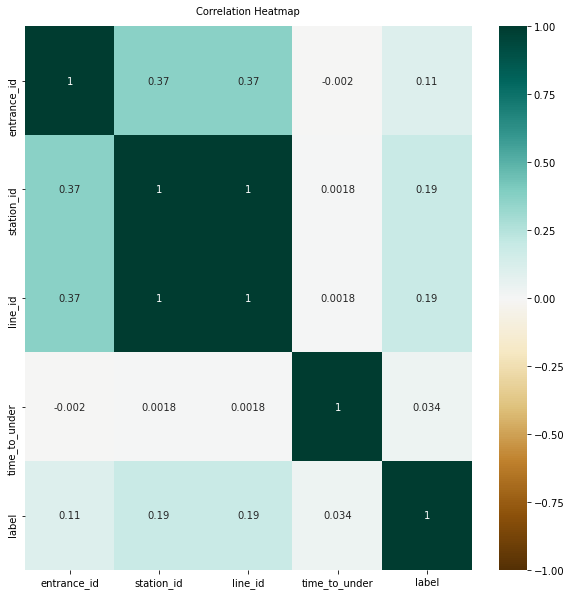

Boxblot для оценки выбросов:


KeyError: "['id'] not found in axis"

In [6]:
data_info(train)

<AxesSubplot:xlabel='label', ylabel='count'>

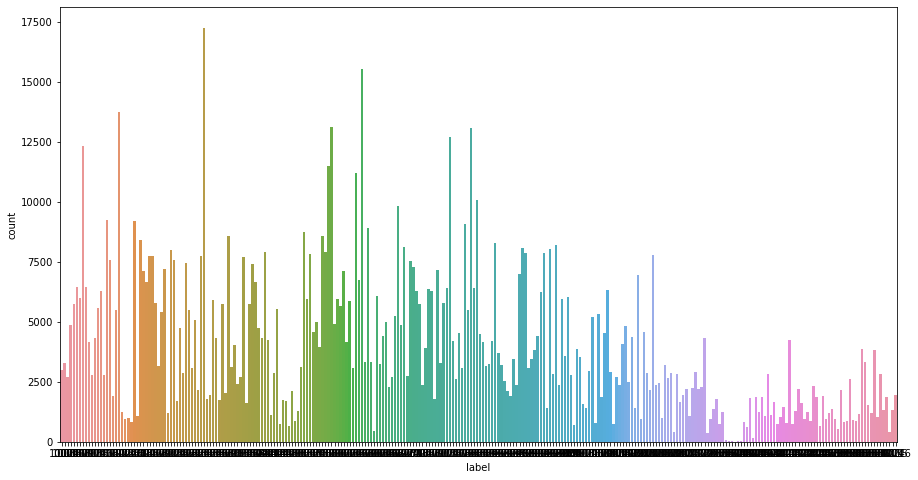

In [12]:
plt.figure(figsize=(15,8))
sns.countplot(x = "label" , data  = train)

In [13]:
train = up_sampling(train, 1500).copy()

In [14]:
#train = down_sampling(train, 1500).copy()

<AxesSubplot:xlabel='label', ylabel='count'>

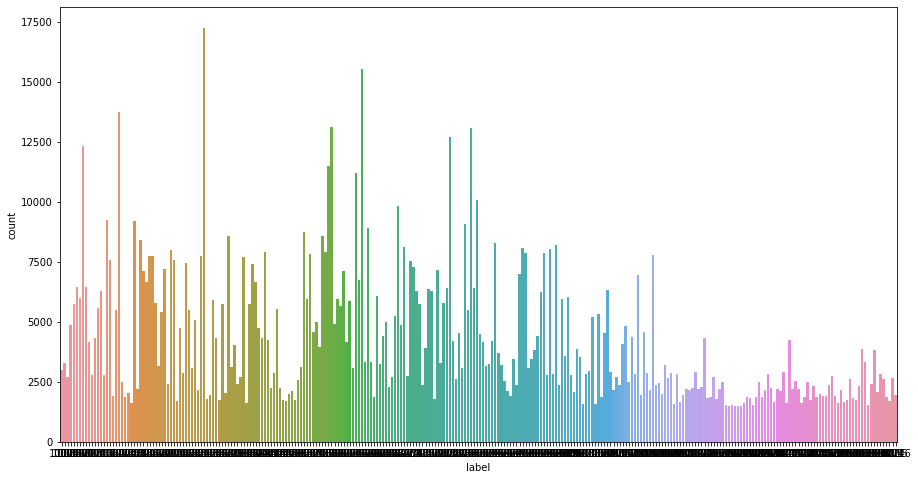

In [15]:
plt.figure(figsize=(15,8))
sns.countplot(x = "label" , data  = train)

# Объеденили в общий датасет

In [16]:
train_df = train.reset_index(drop=True).copy()

In [17]:
test_df = pd.read_csv('test_dataset_test.csv', parse_dates=['pass_dttm']).drop(columns=['id'])
test_df.index = list(range(train_df.index.max()+1, (train_df.index.max()+1+test_df.shape[0])))

In [18]:
y_train = train_df[['time_to_under', 'label']]
train_df = train_df.drop(columns=['time_to_under', 'label'])

In [19]:
main = pd.concat([train_df, test_df], ignore_index=True)

In [20]:
#data_info(main)

# Преобразования

## ticket_type_nm => categorial

In [21]:
main["ticket_type_nm"] = pd.Categorical(main["ticket_type_nm"])
main["ticket_type_nm"].astype('category').cat.codes
main["ticket_type_nm"] = main["ticket_type_nm"].cat.codes

In [22]:
grouped_line = main.groupby('line_id')['station_id'].unique().to_frame('line_length')

In [23]:
new_series = []

for row in grouped_line['line_length']:
    new_series.append(len(row))
    
grouped_line['line_length'] = new_series

In [24]:
# присоеденили line_length и убрали station_id
main = main.merge(grouped_line, on='line_id').set_index(main.index)

# Извлекаем данные из призака времени

In [25]:
main["day_week"] = main.pass_dttm.dt.day_of_week
main["day"] = main.pass_dttm.dt.day
main["hours"] = main.pass_dttm.dt.hour

## Корреляционная матрица

In [26]:
def corr_matrix_save(df: int, title: str):
    """
    Discription:
    ------------
    Функция возвращает heatmap корреляции признаков между собой
    
    Parametrs:
    ------------
    df - датафрейм не содержащий таргета
    title - название таблицы
    
    Returned:
    ------------
    Heatmap
    """
    
    print('Heatmap корреляций:')
    plt.figure(figsize=(10, 10))
    heatmap = sns.heatmap(df.drop(columns=df.select_dtypes(include='object')).corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG') 
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);
    plt.savefig(f"Графики/{title}", )
    plt.show()

# Генерация признаков

In [27]:
# мердж по станциям
route_num_count = subway.groupby(by='start_station_id')['route_num'].size().to_frame('route_num_count')
# колличество развязок с участием станции
alternative_route_cnt = subway.groupby(by='start_station_id').agg({'alternative_route_cnt':'max'})

route_dur = subway.groupby(by='start_station_id').agg({'route_dur':'median'})

optimal_route_delta_median = subway.groupby(by='start_station_id').agg({'optimal_route_delta':'median'})

optimal_route_delta_max = subway.groupby(by='start_station_id').agg({'optimal_route_delta':'max'})

In [28]:
main = main.merge(route_num_count, left_on='station_id', right_on='start_station_id')
main = main.merge(alternative_route_cnt, left_on='station_id', right_on='start_station_id')
main = main.merge(route_dur, left_on='station_id', right_on='start_station_id')
main = main.merge(optimal_route_delta_median, left_on='station_id', right_on='start_station_id')
main = main.merge(optimal_route_delta_max, left_on='station_id', right_on='start_station_id')

In [29]:
main = main.drop(columns=['station_id'])

In [30]:
#corr_matrix_save(main, 'main corr matrix with new features')

# Количество упоминаний конкретной линии и конкретной станции, отображая популярность той или иной точки

In [31]:
# популярность станции
main = main.merge(main.groupby('entrance_id').size().to_frame('count_entrance_id'), on='entrance_id', validate='m:m')

In [32]:
# популярность ветки метро
main = main.merge(main.groupby('line_id').size().to_frame('popularity_line_id') / 10000, on='line_id', validate='m:m')

In [33]:
#corr_matrix_save(main.drop(columns=['time_to_under', 'label']), 'Корреляционная матрица со всеми признаками')

# Убираем object признаки

In [34]:
main = main.select_dtypes(exclude=['object', 'datetime64']).copy()

# PCA (ухудшает метрику)

In [35]:
def pca_concat(main_dataset):
    pca = PCA()
    new_dataframe = pd.DataFrame(data=pca.fit_transform(main), columns=[f"{col}_pca" for col in main.columns])
    
    return pd.merge(main_dataset, new_dataframe, left_index=True, right_index=True) 

In [36]:
#main = pca_concat(main.copy())

# Стандартизация

In [37]:
std = StandardScaler()

In [38]:
main = pd.DataFrame(columns=main.columns, data=std.fit_transform(main))

Heatmap корреляций:


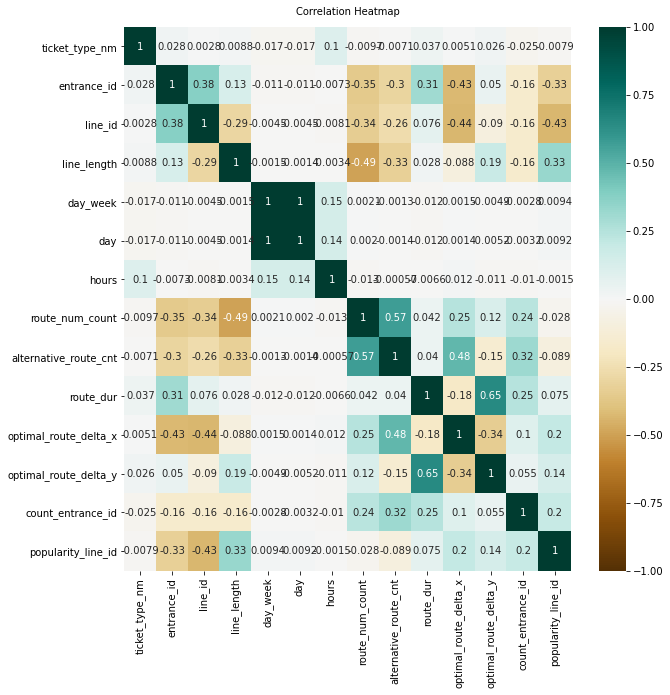

In [39]:
corr_matrix_save(main[main.index.isin(train.index)], 'Корреляционная матрица со всеми признаками + PCA')

# Убираем мультиколлинеарность

In [ ]:
#main = main.drop(columns=['day_pca', 'route_num_count_pca', 
#                                    'optimal_route_delta_x_pca', 'line_id_pca', 
#                                    'day_week_pca', 'entrance_id_pca','line_length', 'day', 'route_dur_pca'])

In [ ]:
#selector = SelectNonCollinear(0.5)

In [ ]:
#selector.fit(main.iloc[train.index])
#mask = selector.get_support()

# Разделение на выборки + выгрузка файла

In [ ]:
train = main[main.index.isin(train_df.index)].drop(columns=main.select_dtypes(include=['object', 'datetime64']).columns)
test = main[main.index.isin(test_df.index)].drop(columns=main.select_dtypes(include=['object', 'datetime64']).columns)

# Сохраняем предобработанные датасеты

In [ ]:
# сохраняем предобработанные файлы
PATH = 'Предподготовленные датасеты/'

train.to_csv(PATH + "train_preprocessed_new_features_scaled_v2_nondownsample.csv")
test.to_csv(PATH + "test_preprocessed_new_features_scaled_v2_nondownsample.csv")

y_train.to_csv(PATH + 'y_train_preprocessed_new_features.csv')

# При необходимости можно подгрузить датасеты отсюда

In [ ]:
PATH = 'Предподготовленные датасеты/'
train = pd.read_csv(PATH + "train_preprocessed_new_features_scaled.csv",index_col=0).drop(columns=['time_to_under','label'])
test = pd.read_csv(PATH + "test_preprocessed_new_features_scaled.csv",index_col=0).drop(columns=['time_to_under','label'])

y_train = pd.read_csv(PATH + 'y_train_preprocessed_new_features.csv',index_col=0)

In [ ]:
display(train.head(5))
display(test.head(5))
display(y_train.head(5))

In [ ]:
main = pd.concat([train, test], ignore_index=True)

In [ ]:
main